# RTBP Problem  : preliminary experiments

<ul id="top">
<li><a href="#Loading-packages"> 
             Loading Packages</a></li>
    
<li><a href="#Computer-properties"> 
             Computer properties</a></li>  

<li><a href="#Initial-value-problem:-RTBP">
             Initial value problem: RTBP</a></li>

<li><a href="#Float64-Computations">
             Float64 Computations</a></li>

<li><a href="#Float128-Computations">
             Float128 Computations</a></li> 

<li><a href="#Error-in-energy">
             Error in energy</a></li> 

</ul>  

## Loading packages

In [1]:
using OrdinaryDiffEq,DiffEqDevTools
using Plots
using Dates,LaTeXStrings
using JLD2, FileIO
using IRKGaussLegendre


<a href="#top">Back to the top</a>

## Computer properties

In [2]:
#export JULIA_NUM_THREADS=2
Threads.nthreads()

4

In [3]:
#;cat /proc/cpuinfo # on Linux machines

In [4]:
using Hwloc
Hwloc.num_physical_cores()

8

<a href="#top">Back to the top</a>

## Initial value problem:  RTBP

In [5]:
setprecision(BigFloat, 108);
include("../ODEProblems/RTBP.jl")
include("../ODEProblems/InitialRTBP.jl")


# One period !! !!!

t0=0.0
t1=parse(Float64,"17.0652165601579625588917206249")

u064,μ64 =InitialRTBP(Float64)
lpp=[μ64]
tspan64=(t0,2*t1)
prob64 = ODEProblem(f,u064,tspan64,[μ64]);

u0128,μ128=InitialRTBP(BigFloat)
tspan128=(BigFloat(t0),parse(BigFloat,"17.0652165601579625588917206249"))
prob128 = ODEProblem(f,u0128,tspan128,[μ128]);
(typeof(u064),typeof(μ64),typeof(tspan64),typeof(u0128),typeof(μ128),typeof(tspan128))

(Vector{Float64}, Float64, Tuple{Float64, Float64}, Vector{BigFloat}, BigFloat, Tuple{BigFloat, BigFloat})

<a href="#top">Back to the top</a>

## Test solution

In [6]:
#u0256,μ256 =InitialRTBP(BigFloat)
#test_sol = TestSolution(tspan128,[u0128])
#test_sol.u[1]-u0256

#apr = appxtrue(sol,test_sol)
#fieldnames(typeof(apr))
#apr.errors

In [7]:
setprecision(BigFloat, 256)
#sol =solve(prob128,Vern9(),save_everystep=false,abstol=1e-32,reltol=1e-32);
#@save "./Data/RTBP_test_sol.jld2" sol

@load "./Data/RTBP_test_sol.jld2" sol
test_sol = TestSolution(sol);
u0256,μ256 =InitialRTBP(BigFloat)

E0=RTBPEnergy(u0256,μ256)
(Float32(sol.t[end]),Float32(RTBPEnergy(sol.u[end],μ256)/E0.-1))

(17.065216f0, 3.207703f-31)

In [8]:
sol.u[end]-u0256

4-element Vector{BigFloat}:
 1.369075264786768121057318603824130743986948245025973792004293347564833795053058e-16
 4.528679613116201218649724232503045903208572638951578867577375925684270718967727e-16
 7.319849936912202620437780646764579807153218571428475689954609725081947952748887e-14
 2.144609421838493516765178753209818387137045946309273520281025349711808833639307e-14

<a href="#top">Back to the top</a>

## Float64 Computations

### Vern9 

In [9]:
sol9 =solve(prob64,Vern9(),abstol=1e-12,reltol=1e-12);
sol9.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  9138
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          534
Number of rejected steps:                          37

### IRKGL16 

In [10]:
sol1 = solve(prob64,IRKGL16(), reltol=1e-12, abstol=1e-12, adaptive=true)
sol1.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  15589
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          137
Number of rejected steps:                          25

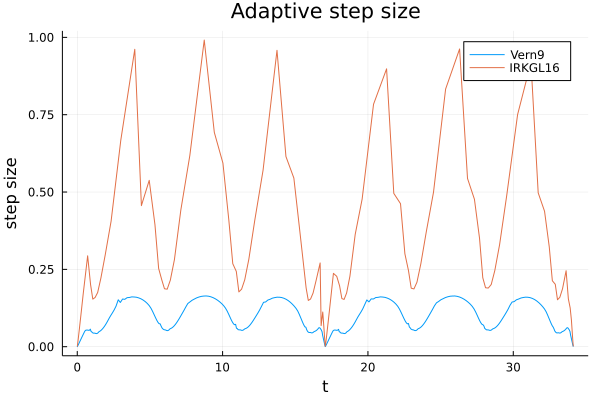

In [11]:
steps9 =sol9.t[2:end]-sol9.t[1:end-1]
steps1 =sol1.t[2:end]-sol1.t[1:end-1]
plot(xlabel="t", ylabel="step size",title="Adaptive step size")
plot!(sol9.t[2:end],steps9, label="Vern9")
plot!(sol1.t[2:end],steps1, label="IRKGL16")

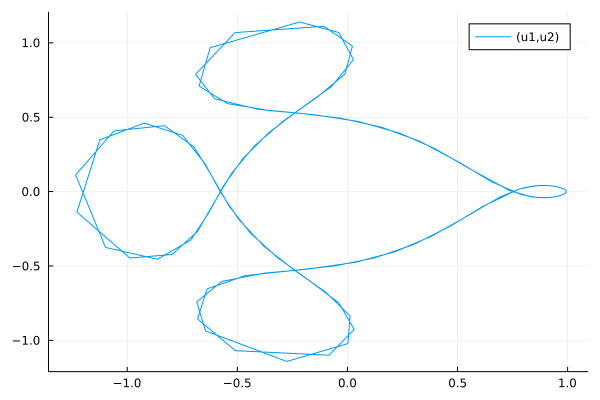

In [12]:
plot(sol1,vars=(1,2))

<a href="#top">Back to the top</a>

## Float128 Computations

In [13]:
setprecision(BigFloat, 108);

### Vern9

In [14]:
sol19 =solve(prob128,Vern9(),abstol=1e-20,reltol=1e-20);
sol19.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  32754
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          2044
Number of rejected steps:                          3

### IRKGL16 

In [15]:
sol11 = solve(prob128,IRKGL16(mixed_precision=false), reltol=1e-20, abstol=1e-20, adaptive=true)
sol11.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  27406
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          204
Number of rejected steps:                          20

### IRKGL16 (Mixed-Precision)

In [16]:
sol12 = solve(prob128,IRKGL16(mixed_precision=true),reltol=1e-12, abstol=1e-12,adaptive=true)
sol12.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  4731
Number of function 2 evaluations:                  40980
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          69
Number of rejected steps:                          13

<a href="#top">Back to the top</a>

## Error in energy

In [17]:
setprecision(BigFloat, 256)
u0256, μ256 =InitialRTBP(BigFloat)

E0=RTBPEnergy(u0256,μ256)

ΔE1 = map(x->RTBPEnergy(BigFloat.(x),μ256), sol1.u)./E0.-1
ΔE9 = map(x->RTBPEnergy(BigFloat.(x),μ256), sol9.u)./E0.-1
ΔE11 = map(x->RTBPEnergy(BigFloat.(x),μ256), sol11.u)./E0.-1
ΔE12 = map(x->RTBPEnergy(BigFloat.(x),μ256), sol12.u)./E0.-1
ΔE19 = map(x->RTBPEnergy(BigFloat.(x),μ256), sol19.u)./E0.-1
(Float32(maximum(abs.(ΔE1))),Float32(maximum(abs.(ΔE9))) ,Float32(maximum(abs.(ΔE11))),Float32(maximum(abs.(ΔE12))) ,Float32(maximum(abs.(ΔE19))))

(6.512765f-15, 5.4017863f-13, 6.940512f-23, 5.436555f-15, 4.0110475f-22)

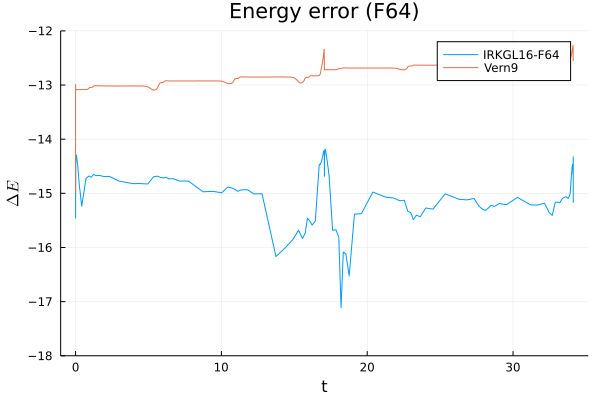

In [18]:
ylimit1=-18
ylimit2=-12
plot(title="Energy error (F64)", xlabel="t", ylabel=L"\Delta E")
plot!(sol1.t,log10.(abs.(ΔE1)), label="IRKGL16-F64",
     ylims=(ylimit1,ylimit2),)
plot!(sol9.t,log10.(abs.(ΔE9)), label="Vern9",
     ylims=(ylimit1,ylimit2),)

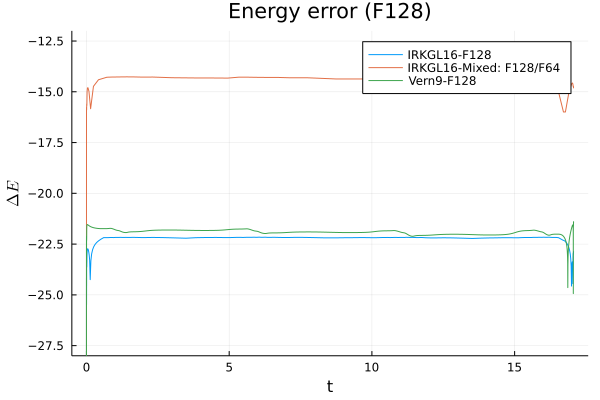

In [19]:
ylimit1=-28
ylimit2=-12
plot(title="Energy error (F128)", xlabel="t", ylabel=L"\Delta E")
plot!(sol11.t,log10.(abs.(ΔE11)), label="IRKGL16-F128",
     ylims=(ylimit1,ylimit2),)
plot!(sol12.t,log10.(abs.(ΔE12)), label="IRKGL16-Mixed: F128/F64",
     ylims=(ylimit1,ylimit2),)
plot!(sol19.t,log10.(abs.(ΔE19)), label="Vern9-F128",
     ylims=(ylimit1,ylimit2),)

<a href="#top">Back to the top</a>